In [2]:
import numpy as np
def rdnumpy(txtname):
    f = open(txtname)
    line = f.readlines()
    lines = len(line)  # row number
    for l in line:
        le = l.strip('\n').split(',')
        columns = len(le)-1  # col
        #print(le)
        #print(columns)
 
    A = np.zeros((lines, columns+1), dtype=np.single)
    print("read lines:",lines)
    print("read columns:",columns+1)
    A_row = 0
    for lin in line:
        #print(A_row)
        list = lin.strip('\n').split(',')
        A[A_row:] = list[0:columns+1]
        A_row += 1
    return A

In [3]:
#### Train &Test: 3360+1440

# Model

In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor, ToPILImage, Lambda
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [5]:
n_epochs = 3
batch_size_train = 6 #32,或者16-由於數據集比較小
batch_size_test = 1440*3
learning_rate = 0.00001 #0.0001
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

# test

In [6]:
class ScottTrainDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        TrainDataf1=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\AllRat\MTrainGf1.txt"))
        TrainDataw0=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\AllRat\MTrainGw0.txt"))
        TrainDatam3=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\AllRat\MTrainGm3.txt"))
        #TrainDataq4=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTrainGq4.txt"))
        
        self.AllTrainData=torch.cat((TrainDataw0,TrainDataf1,TrainDatam3),0)
        # 定义transform
        self.transform = transform
        self.target_transform = target_transform
 
    def __len__(self):
        '''返回数据集中的样本数'''
        return 1725*3
 
    def __getitem__(self, index):#需要第index個的數據
        '''获取数据的方法，会和Dataloader连用'''
        i=index;        
        startRow=i*8;
        enRow=(i+1)*8;
        nowData=self.AllTrainData[startRow:enRow,2:7]
        
        if index>=0 and index<1725:
            nowLabel=1
        elif index>=1725 and index<1725*2:
            nowLabel=0
        elif index>=1725*2 and index<1725*3:
            nowLabel=2
            
        if self.transform:
            nowData = self.transform(nowData)
        if self.target_transform:
            nowLabel = self.target_transform(nowLabel)
        '''
        if nowLabel==0:
            nowLabel = torch.FloatTensor([1, 0])
        else:
            nowLabel = torch.FloatTensor([0, 1])
        '''
        return nowData, nowLabel#需要返回數據和標簽

In [7]:
class ScottTestDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        TestDataf1=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\AllRat\MTestGf1.txt"))
        TestDataw0=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\AllRat\MTestGw0.txt"))
        TestDatam3=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\AllRat\MTestGm3.txt"))
        #TestDataq4=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\AllRat\MTestGq4.txt"))
        
        self.AllTrainData=torch.cat((TestDataw0,TestDataf1,TestDatam3),0)
        # 定义transform
        self.transform = transform
        self.target_transform = target_transform
 
    def __len__(self):
        '''返回数据集中的样本数'''
        return 725*3
 
    def __getitem__(self, index):#需要第index個的數據
        '''获取数据的方法，会和Dataloader连用'''
        i=index;        
        startRow=i*8;
        enRow=(i+1)*8;
        nowData=self.AllTrainData[startRow:enRow,2:7]
        
        if index>=0 and index<725:
            nowLabel=1
        elif index>=725 and index<725*2:
            nowLabel=0
        elif index>=725*2 and index<725*3:
            nowLabel=2
            
        if self.transform:
            nowData = self.transform(nowData)
        if self.target_transform:
            nowLabel = self.target_transform(nowLabel)
            
        '''
        if nowLabel==0:
            nowLabel = torch.FloatTensor([1, 0])
        else:
            nowLabel = torch.FloatTensor([0, 1])
        '''
            
        return nowData, nowLabel#需要返回數據和標簽

In [8]:
train_loader = torch.utils.data.DataLoader(ScottTrainDataset(),
    batch_size=batch_size_train, shuffle=True)


test_loader = torch.utils.data.DataLoader(ScottTestDataset(),
    batch_size=batch_size_test, shuffle=True)

read lines: 13800
read columns: 9
read lines: 13800
read columns: 9
read lines: 13800
read columns: 9
read lines: 5800
read columns: 9
read lines: 5800
read columns: 9
read lines: 5800
read columns: 9


# Network

In [9]:
#https://zhuanlan.zhihu.com/p/199624393
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(10,20, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(40, 15)
        self.fc2 = nn.Linear(15, 3)
    def forward(self, x):
        ##print(x)##
        print("begin")
        print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        print("relu1:")
        print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        print("relu2:")
        print(x.shape)
        x = x.view(-1,40)
        print("view:")
        print(x.shape)
        x = F.relu(self.fc1(x))
        print("relu3:")
        print(x.shape)
        x = F.dropout(x, training=self.training) 
        print("dropout")
        print(x.shape)
        x = self.fc2(x)
        print("fc2")
        print(x.shape)
        return F.log_softmax(x, dim=-1)
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [10]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

# Train

In [11]:
#for batch_idx, (data, target) in enumerate(train_loader):
        #print(data.shape)
        #print(data)

In [12]:
train_losses = []
train_counter = []

def train(epoch):
  for _ in range(epoch):
      network.train()
      for batch_idx, (data, target) in enumerate(train_loader):
        #if batch_idx>1920 and batch_idx<1920+320: continue
        optimizer.zero_grad()
        data = data.unsqueeze(1)
        #print(data.shape)
        #print(data)
        output = network(data)
        #print(target.shape, target, output)
        #assert 1==0
        #loss = F.binary_cross_entropy_with_logits(output, target)
        ##
        #print("output:")
        #print(output)
        #print("target:")
        #print(target)
        #print(target.shape)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        '''
        print(torch.isnan(data).sum(), (target==1).sum()+(target==0).sum())
        assert (target==1).sum()+(target==0).sum()==16
        print(torch.isnan(data).sum(), target.shape, target, output)
        if torch.isnan(output).sum()!=0:
            print(data, target, torch.isnan(data).sum())
            print(data[-5])
        assert torch.isnan(output).sum()==0
        assert torch.isnan(loss).sum()==0
        '''
        if batch_idx % log_interval == 0:
          #print(torch.isnan(data).sum(), target.shape, target, output)
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            _ , batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
          train_losses.append(loss.item())
          train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
          torch.save(network.state_dict(), './model.pth')
          torch.save(optimizer.state_dict(), './optimizer.pth')
          #print(network.state_dict())
    
train(1)

begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
Train Epoch: 0 [0/5175 (0%)]	Loss: 1.135786
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dr

relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8,

relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
Train Epoch: 0 [1020/5175 (20%)]	Loss: 1.122811
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
f

view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2,

Train Epoch: 0 [1920/5175 (37%)]	Loss: 1.045291
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15]

relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
Train Epoch: 0 [2400/5175 (46%)]	Loss: 1.149099
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
f

relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4,

relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8,

relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
Train Epoch: 0 [3840/5175 (74%)]	Loss: 1.069880
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
f

dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
Train Epoch: 0 [4320/5175 (83%)]	Loss: 1.099366
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])


relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
begin
torch.Size([6, 1, 8, 5])
relu1:
torch.Size([6, 10, 4, 3])
relu2:
torch.Size([6, 20, 2, 1])
view:
torch.Size([6, 40])
relu3:
torch.Size([6, 15])
dropout
torch.Size([6, 15])
fc2
torch.Size([6, 3])
Train Epoch: 0 [4800/5175 

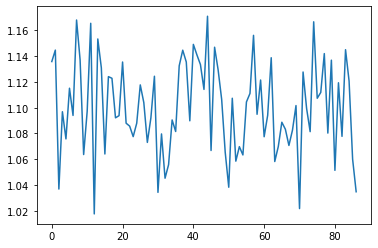

In [13]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt

plt.plot(list(range(len(train_losses))), train_losses)
plt.show()

In [14]:
'''
for p in network.parameters():
    print(p)
    break
tmp = torch.load('./model.pth')
network.load_state_dict(tmp)
for p in network.parameters():
    print(p)
    break
'''

"\nfor p in network.parameters():\n    print(p)\n    break\ntmp = torch.load('./model.pth')\nnetwork.load_state_dict(tmp)\nfor p in network.parameters():\n    print(p)\n    break\n"

In [15]:
import scipy.io as io
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.unsqueeze(1)
      #print("data:")
      #print(data.shape)
      output = network(data)
      #print("output:")
      #print(output.shape)
      
      test_loss += F.nll_loss(output, target, size_average=False).item()
      #print(output)
      pred = output.data.max(1, keepdim=True)[1]
      #print(pred)###
      result1 = np.array(pred)
      np.savetxt('pred.txt',result1)
      result2 = np.array(target)
      np.savetxt('target.txt',result2)
      
      #Save done
      correct += pred.eq(target.data.view_as(pred)).sum()
      
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
test()

begin
torch.Size([2175, 1, 8, 5])
relu1:
torch.Size([2175, 10, 4, 3])
relu2:
torch.Size([2175, 20, 2, 1])
view:
torch.Size([2175, 40])
relu3:
torch.Size([2175, 15])
dropout
torch.Size([2175, 15])
fc2
torch.Size([2175, 3])

Test set: Avg. loss: 1.0961, Accuracy: 725/2175 (33.33%)



C:\Users\PCI\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [16]:
'''
import scipy.io as io
result1 = np.array(result1)
np.savetxt('npresult1.txt',result1)
'''

"\nimport scipy.io as io\nresult1 = np.array(result1)\nnp.savetxt('npresult1.txt',result1)\n"

In [17]:
'''
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()
'''

"\nfor epoch in range(1, n_epochs + 1):\n  train(epoch)\n  test()\nimport matplotlib.pyplot as plt\nfig = plt.figure()\nplt.plot(train_counter, train_losses, color='blue')\nplt.scatter(test_counter, test_losses, color='red')\nplt.legend(['Train Loss', 'Test Loss'], loc='upper right')\nplt.xlabel('number of training examples seen')\nplt.ylabel('negative log likelihood loss')\nplt.show()\n"

# confusion matrix

In [18]:
  import scipy.io as io
  test_losses = []
  test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.unsqueeze(1)
      #print("data:")
      #print(data.shape)
      output = network(data)
      #print("output:")
      #print(output.shape)
      
      test_loss += F.nll_loss(output, target, size_average=False).item()
      #print(output)
      pred = output.data.max(1, keepdim=True)[1]
      #print(pred)###
      result1 = np.array(pred)
      #np.savetxt('pred.txt',result1)
      result2 = np.array(target)
      #np.savetxt('target.txt',result2)
      
      #Save done
      correct += pred.eq(target.data.view_as(pred)).sum()
      
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

begin
torch.Size([2175, 1, 8, 5])
relu1:
torch.Size([2175, 10, 4, 3])
relu2:
torch.Size([2175, 20, 2, 1])
view:
torch.Size([2175, 40])
relu3:
torch.Size([2175, 15])
dropout
torch.Size([2175, 15])
fc2
torch.Size([2175, 3])

Test set: Avg. loss: 1.0961, Accuracy: 725/2175 (33%)



In [19]:
from sklearn.metrics import f1_score
 
y_true = target
y_pred = pred
 
print(f1_score(y_true, y_pred, average='weighted'))# unbalance F1
print(f1_score(y_true, y_pred, average='macro'))
print()
print(f1_score(y_true, y_pred, average=None))
print("Acute       Normal      Chronic")

0.16666666666666666
0.16666666666666666

[0.5 0.  0. ]
Acute       Normal      Chronic


[[100.   0.   0.]
 [100.   0.   0.]
 [100.   0.   0.]]


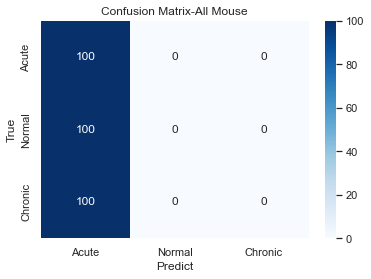

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

sns.set()
f,ax = plt.subplots()
y_true =(target)
y_pred = (pred)
C2 = confusion_matrix(y_true,y_pred,labels=[0,1,2])

fm=C2.sum(axis=1)
C3=C2/fm*100
C3=np.around(C3,decimals=2)

print(C3)
a=sns.heatmap(C3,annot=True,ax=ax, cmap = 'Blues', fmt='g') #画热力图  , cbar = None

ax.set_title('Confusion Matrix-All Mouse') #标题
ax.set_xlabel('Predict') #x 轴
ax.set_ylabel('True') #y 轴


#Normal, Acute, Chronic, Pre-seizure
a.set_xticklabels(['Acute','Normal','Chronic'])
a.set_yticklabels(['Acute','Normal','Chronic'])


fig = a.get_figure()
fig.savefig("6F_3C.png", dpi=1080)